In [1]:
ls

 Attention_imdb.ipynb       cnn_kd_twitter.ipynb
 Attention_tiwtter.ipynb    cnn_twitter.ipynb
'bert_gru_tiwtter .ipynb'   kd_atten_lstm_imdb.ipynb
 bert_imdb.ipynb            kd_lstm_imdb.ipynb
 bert_linear_imdb.ipynb     lstm_baseline.ipynb
 bert_twitter.ipynb         lstm_basline_Twitter.ipynb
 cnn_imdb.ipynb             lstm_kd_atten_twitter.ipynb
 cnn_kd.ipynb               lstm_kd_twitter.ipynb


In [2]:
cd ..

/project/6006178/dongxx


In [3]:
cd LSTMbaseline/

/project/6006178/dongxx/LSTMbaseline


In [4]:
test = '/home/dongxx/projects/def-parimala/dongxx/data/test.csv'
valid = '/home/dongxx/projects/def-parimala/dongxx/data/valid.csv'
train ='/home/dongxx/projects/def-parimala/dongxx/data/train.csv'

In [5]:
from models import CNN_Baseline,LSTMBaseline,BERT

from run_bert_training_classifier import prepare_dateset,validate,generate_batch,epoch_time
import torch
import torch.nn as nn
import numpy as np
from models import BERTGRUSentiment
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe,Vocab,Vectors
from tqdm import tqdm
from utils import IMDB_indexing, pad_sequenc,pad_sequencing
from models import CNN_Baseline,LSTMBaseline
import torchtext.vocab
import csv
import pandas as pd
import argparse
import logging
import os
import pickle
import sys
import config
config.seed_torch()
from collections import Counter
import time
import copy

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from transformers import BertTokenizer, BertModel

In [8]:
bert = BertModel.from_pretrained('bert-base-uncased')
Bert_model = BERT(bert)
Bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [9]:
train_dataset, validation_dataset,test_dataset,labellist = prepare_dateset(train, valid,test)
testing = DataLoader(test_dataset, collate_fn= generate_batch, batch_size=8, shuffle=False)

Start loading training data
Finish loading training data
Start loading validation data
Finish loading validation data
Start loading testing data
Finish loading testing data
prepare training and test sets


In [10]:
Bert_model.load_state_dict(torch.load(config.BERT_ft_PATH))
criterion = nn.CrossEntropyLoss()
criterion.to(device)
start_time = time.time()
test_loss, test_acc,flat_list = validate(testing, Bert_model, criterion, device)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f' | Epoch Time: {epoch_mins}m {epoch_secs}s')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 | Epoch Time: 10m 15s


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import itertools
pred_list =[item.cpu().numpy() for sublist in flat_list for item in sublist]
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Test Loss: 0.197 | Test Acc: 92.75%


In [12]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


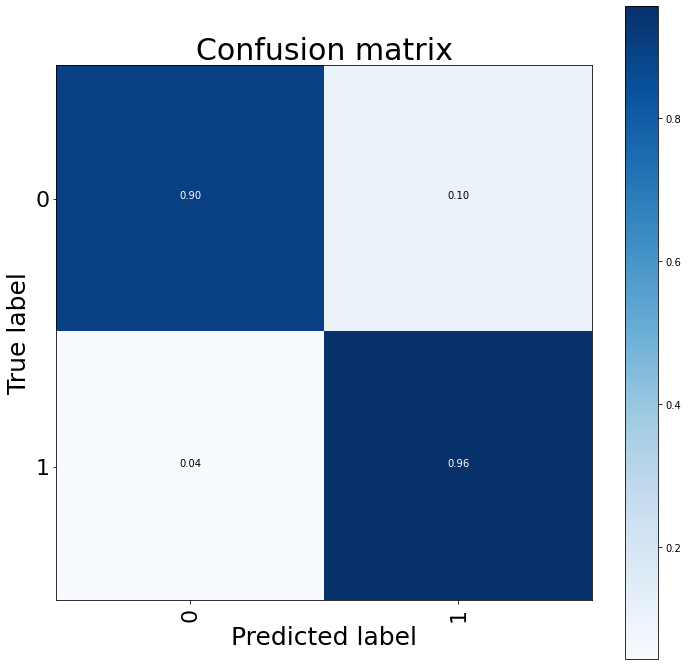

              precision    recall  f1-score   support

           0     0.9540    0.8983    0.9253     12500
           1     0.9039    0.9566    0.9295     12500

    accuracy                         0.9275     25000
   macro avg     0.9289    0.9275    0.9274     25000
weighted avg     0.9289    0.9275    0.9274     25000



In [13]:
cnf_matrix = confusion_matrix(labellist, pred_list)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix")
plt.show()
print(classification_report(labellist, pred_list,digits =4))